In [ ]:
!pip install interpret

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#To display all the columns and rows
pd.set_option('display.max_columns', 1000);
pd.set_option('display.max_rows', 1000);
pd.set_option('display.width', 1000);
#To ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
#To supress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
#Reading the three different cases of dataset that were pre processed
case_1_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/case_1_dataset.csv")
case_2_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/case_2_dataset.csv")
case_3_df = pd.read_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/case_3_dataset.csv")

## 1. Dataset division based on class

In [ ]:
#Creating a separate dataframe for late diagnosis records and removing them from training
#Filter rows where future_rare_skin == 1
future_rare_skin_case_1 = case_1_df[case_1_df['future_rare_skin'] == 1]
future_rare_skin_case_2 = case_2_df[case_2_df['future_rare_skin'] == 1]
future_rare_skin_case_3 = case_3_df[case_3_df['future_rare_skin'] == 1]

#Remove those rows from original dataframes
case_1_df = case_1_df[case_1_df['future_rare_skin'] != 1].copy()
case_2_df = case_2_df[case_2_df['future_rare_skin'] != 1].copy()
case_3_df = case_3_df[case_3_df['future_rare_skin'] != 1].copy()

#Drop the column from the updated dataframes
case_1_df.drop(columns=['future_rare_skin'], inplace=True)
case_2_df.drop(columns=['future_rare_skin'], inplace=True)
case_3_df.drop(columns=['future_rare_skin'], inplace=True)

#Check the shapes
print(f"future_rare_skin_df shape: {future_rare_skin_case_2.shape}")
print(f"case_1_df shape after removal: {case_1_df.shape}")
print(f"case_2_df shape after removal: {case_2_df.shape}")
print(f"case_3_df shape after removal: {case_3_df.shape}")

future_rare_skin_df shape: (806, 122)
case_1_df shape after removal: (9533, 121)
case_2_df shape after removal: (10033, 121)
case_3_df shape after removal: (4230, 152)


In [ ]:
# Dictionary mapping case names to loaded DataFrames
case_dfs = {
    "case_1": case_1_df,
    "case_2": case_2_df,
    "case_3": case_3_df
}

# Define sample sizes for combo_dataset
combo_sample_sizes = {
    "case_1": 600,
    "case_2": 700,
    "case_3": 100
}

# Store processed datasets
all_datasets = {}

for case_name, df in case_dfs.items():
    print(f"Processing {case_name}...")

    # Rare skin diseases (positive class)
    rare_skin_df = df[df['class'] == 1]

    # Common diseases (class 4)
    common_df = df[df['class'] == 4]
    common_dataset = pd.concat([rare_skin_df, common_df])

    # Rare diseases (class 3)
    rare_df = df[df['class'] == 3]
    rare_dataset = pd.concat([rare_skin_df, rare_df])

    # Common skin diseases (class 2)
    common_skin_df = df[df['class'] == 2]
    common_skin_dataset = pd.concat([rare_skin_df, common_skin_df])

    # Combo dataset: rare skin diseases + sample from class 2, 3, 4
    sample_size = combo_sample_sizes[case_name]
    combo_neg_df = pd.concat([
        common_skin_df.sample(n=min(sample_size, len(common_skin_df)), random_state=42),
        rare_df.sample(n=min(sample_size, len(rare_df)), random_state=42),
        common_df.sample(n=min(sample_size, len(common_df)), random_state=42)
    ])
    combo_dataset = pd.concat([rare_skin_df, combo_neg_df])

    # Store the generated datasets
    all_datasets[case_name] = {
        "common_dataset": common_dataset.reset_index(drop=True),
        "rare_dataset": rare_dataset.reset_index(drop=True),
        "common_skin_dataset": common_skin_dataset.reset_index(drop=True),
        "combo_dataset": combo_dataset.reset_index(drop=True),
    }

print("✅ All case datasets processed and stored in `all_datasets`.")

Processing case_1...
Processing case_2...
Processing case_3...
✅ All case datasets processed and stored in `all_datasets`.


In [ ]:
#Dropping unnecessary columns from all the datasets.
cols_to_drop = ['subject_id', 'hadm_id', 'seq_num', 'class', 'is_first_admission', 'time_to_diagnosis', 'days_to_next_admission']

for case_name in all_datasets:
    for dataset_name in all_datasets[case_name]:
        df = all_datasets[case_name][dataset_name]
        all_datasets[case_name][dataset_name] = df.drop(columns=cols_to_drop).reset_index(drop=True)


📊 Target distribution plots for case_1


/tmp/ipython-input-9-1327189992.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.countplot(x='target', data=df, palette=palette)
/tmp/ipython-input-9-1327189992.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.countplot(x='target', data=df, palette=palette)
/tmp/ipython-input-9-1327189992.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.countplot(x='target', data=df, palette=palette)
/tmp/ipython-input-9-1327189992.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.countplot(x='target', data=df, palette=palette)


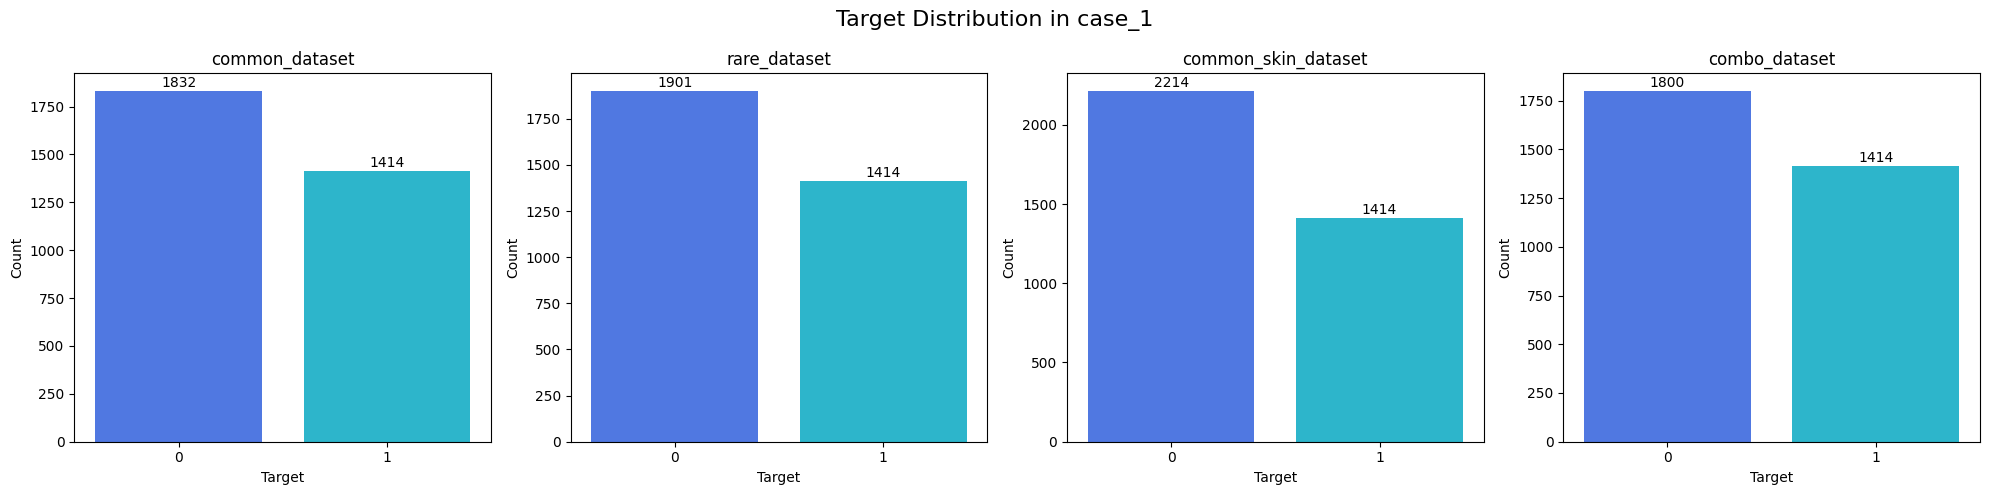


📊 Target distribution plots for case_2


/tmp/ipython-input-9-1327189992.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.countplot(x='target', data=df, palette=palette)
/tmp/ipython-input-9-1327189992.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.countplot(x='target', data=df, palette=palette)
/tmp/ipython-input-9-1327189992.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.countplot(x='target', data=df, palette=palette)
/tmp/ipython-input-9-1327189992.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.countplot(x='target', data=df, palette=palette)


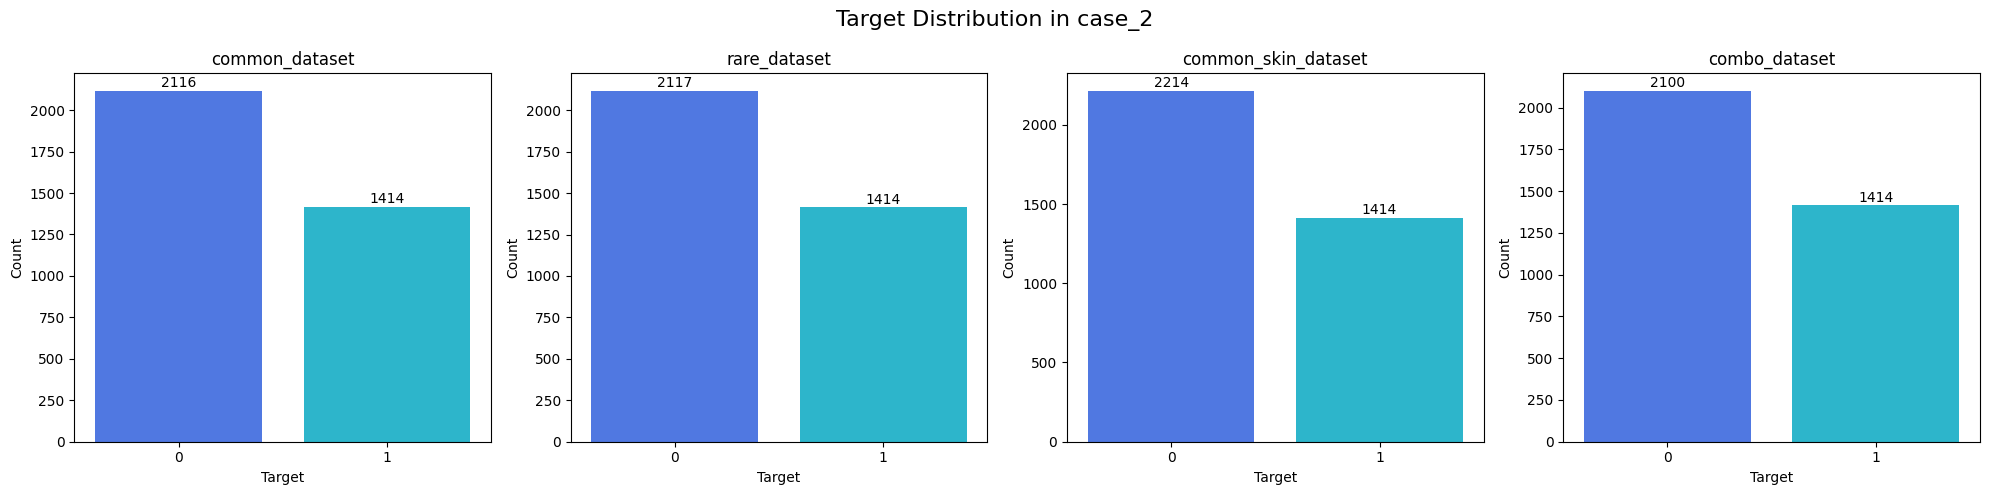


📊 Target distribution plots for case_3


/tmp/ipython-input-9-1327189992.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.countplot(x='target', data=df, palette=palette)
/tmp/ipython-input-9-1327189992.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.countplot(x='target', data=df, palette=palette)
/tmp/ipython-input-9-1327189992.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.countplot(x='target', data=df, palette=palette)
/tmp/ipython-input-9-1327189992.py:14: UserWarning: The palette list has more values (6) than needed (2), which may not be intended.
  ax = sns.countplot(x='target', data=df, palette=palette)


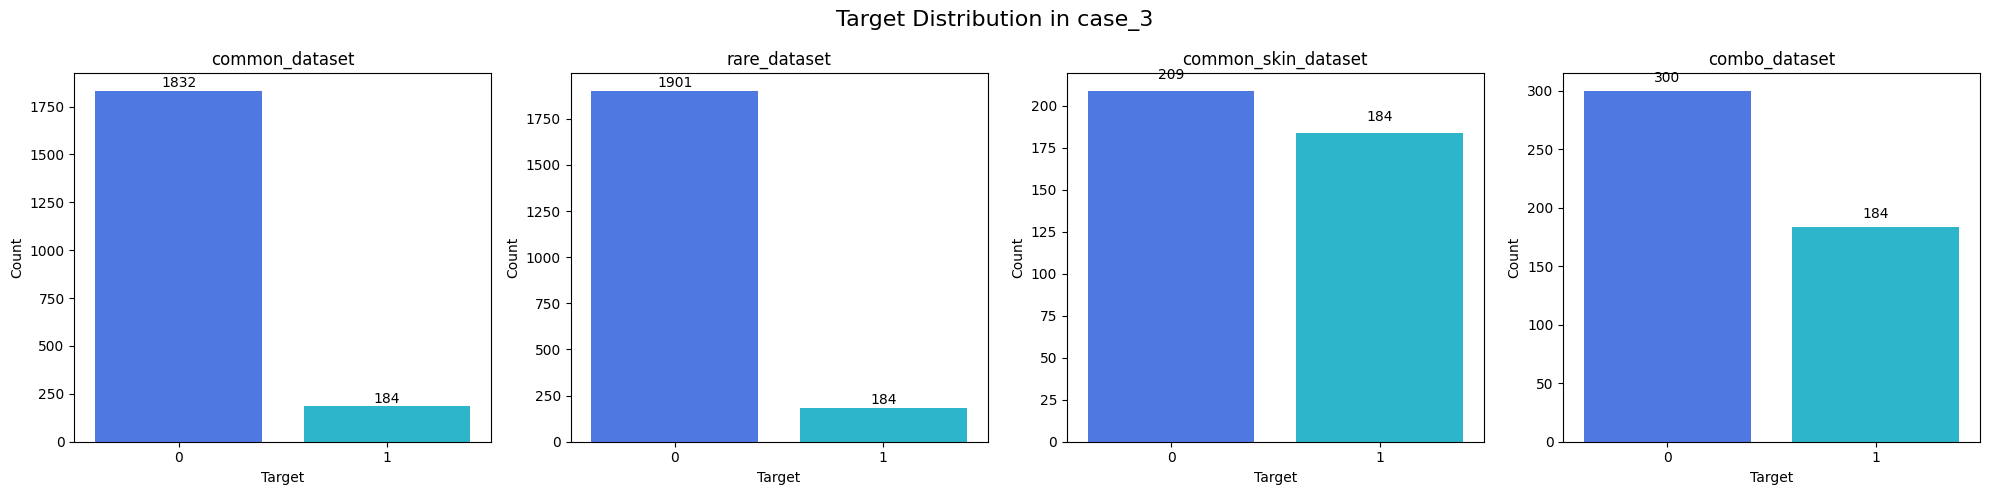

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("rainbow")

# Loop through each case (case_1, case_2, case_3)
for case_name, datasets in all_datasets.items():
    print(f"\n📊 Target distribution plots for {case_name}")

    plt.figure(figsize=(20, 5))

    for i, (dataset_name, df) in enumerate(datasets.items(), 1):
        plt.subplot(1, 4, i)
        ax = sns.countplot(x='target', data=df, palette=palette)
        plt.title(f'{dataset_name}')
        plt.xlabel('Target')
        plt.ylabel('Count')

        # Add count labels on bars
        for p in ax.patches:
            height = p.get_height()
            ax.text(p.get_x() + p.get_width() / 2., height + 5, int(height), ha='center', va='bottom')

    plt.suptitle(f'Target Distribution in {case_name}', fontsize=16)
    plt.tight_layout()
    plt.show()


## 2. Model Building with multiple datasets

### 2.1 Baseline Datasets

Case 1 - Records with no missing imputed data in class 3 and 4.

Case 2 - Records with missing imputed data in all classes.

Case 3 - Records with no missing data in any classes.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_recall_curve, auc, precision_score, recall_score,
    f1_score, accuracy_score
)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Store results
all_results = []

# Loop through each case and dataset
for case_name, datasets in all_datasets.items():
    for dataset_name, df in datasets.items():
        print(f"\n🔍 Processing: {case_name} - {dataset_name}")

        # Features and target
        X = df.drop(columns=['target'])
        y = df['target']

        # Train/test split
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.20, stratify=y, random_state=42
        )

        # Train Random Forest
        model = RandomForestClassifier(random_state=42)
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        # Confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        specificity = tn / (tn + fp)
        f1 = f1_score(y_test, y_pred)
        fpr = fp / (fp + tn)
        roc_auc = roc_auc_score(y_test, y_prob)
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_curve, precision_curve)

        # Append results
        all_results.append({
            "Case": case_name,
            "Dataset": dataset_name,
            "TP": tp,
            "FP": fp,
            "TN": tn,
            "FN": fn,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "Specificity": specificity,
            "F1 Score": f1,
            "FPR": fpr,
            "ROC AUC": roc_auc,
            "PR AUC": pr_auc
        })

# Convert to DataFrame
results_df = pd.DataFrame(all_results)

# Display
print("\n📊 Final Evaluation Results:")
print(results_df)

# Optional: Save to CSV
results_df.to_csv("random_forest_evaluation_metrics_all_cases.csv", index=False)


🔍 Processing: case_1 - common_dataset

🔍 Processing: case_1 - rare_dataset

🔍 Processing: case_1 - common_skin_dataset

🔍 Processing: case_1 - combo_dataset

🔍 Processing: case_2 - common_dataset

🔍 Processing: case_2 - rare_dataset

🔍 Processing: case_2 - common_skin_dataset

🔍 Processing: case_2 - combo_dataset

🔍 Processing: case_3 - common_dataset

🔍 Processing: case_3 - rare_dataset

🔍 Processing: case_3 - common_skin_dataset

🔍 Processing: case_3 - combo_dataset

📊 Final Evaluation Results:
      Case              Dataset   TP   FP   TN   FN  Accuracy  Precision  Recall  Specificity  F1 Score   FPR  ROC AUC  PR AUC
0   case_1       common_dataset  246    3  364   37     0.938      0.988   0.869        0.992     0.925 0.008    0.975   0.977
1   case_1         rare_dataset  246    2  378   37     0.941      0.992   0.869        0.995     0.927 0.005    0.953   0.961
2   case_1  common_skin_dataset   85   56  387  198     0.650      0.603   0.300        0.874     0.401 0.126    0.6

In [ ]:
import pandas as pd

def compute_missing_percentages(all_datasets):
    """
    all_datasets: dict of the form
      {
        "case_1": {
          "common_dataset": DataFrame,
          "rare_dataset": DataFrame,
          ...
        },
        "case_2": { ... },
        "case_3": { ... }
      }
    """
    results = []

    for case_name, datasets in all_datasets.items():
        for dataset_name, df in datasets.items():
            # drop ’target’ when counting features
            n_features = df.shape[1] - 1
            for target_val in [0, 1]:
                subset = df[df['target'] == target_val]
                total_values = subset.shape[0] * n_features
                missing_count = (subset.drop(columns=['target']) == -99999).sum().sum()
                missing_pct = (missing_count / total_values) * 100 if total_values > 0 else 0

                results.append({
                    "Case":       case_name,
                    "Dataset":    dataset_name,
                    "Target":     target_val,
                    "Total Cells": total_values,
                    "Missing Count": missing_count,
                    "% Missing (-99999)": round(missing_pct, 2)
                })

    return pd.DataFrame(results)

# --- Example usage ---
missing_summary = compute_missing_percentages(all_datasets)
print(missing_summary)

# If you want to pivot for easier reading:
pivot = missing_summary.pivot_table(
    index=["Case","Dataset"],
    columns="Target",
    values="% Missing (-99999)"
).rename(columns={0: "%Missing_Target0", 1: "%Missing_Target1"})
#print(pivot)


      Case              Dataset  Target  Total Cells  Missing Count  % Missing (-99999)
0   case_1       common_dataset       0       207016              0               0.000
1   case_1       common_dataset       1       159782           4713               2.950
2   case_1         rare_dataset       0       214813              0               0.000
3   case_1         rare_dataset       1       159782           4713               2.950
4   case_1  common_skin_dataset       0       250182           9284               3.710
5   case_1  common_skin_dataset       1       159782           4713               2.950
6   case_1        combo_dataset       0       203400           2519               1.240
7   case_1        combo_dataset       1       159782           4713               2.950
8   case_2       common_dataset       0       239108           1637               0.680
9   case_2       common_dataset       1       159782           5379               3.370
10  case_2         rare_dataset 

In [ ]:
pivot

Target                      %Missing_Target0  %Missing_Target1
Case   Dataset                                                
case_1 combo_dataset                   1.240             2.950
       common_dataset                  0.000             2.950
       common_skin_dataset             3.710             2.950
       rare_dataset                    0.000             2.950
case_2 combo_dataset                   1.790             3.370
       common_dataset                  0.680             3.370
       common_skin_dataset             4.240             3.370
       rare_dataset                    0.450             3.370
case_3 combo_dataset                   0.000             0.000
       common_dataset                  0.000             0.000
       common_skin_dataset             0.000             0.000
       rare_dataset                    0.000             0.000

We can see that case 1 is giving very good results because missigness is becoming a feature that can differentiate between positive and negative class. This can be an error that people overlook (because people assume missigness to be a learning) and result in inflated results. Therefore, now we are removing case 1 and going ahead with feature reduction for case 2 and case 3 datasets.

### 2.2 Feature Reduction Methods

In [ ]:
!pip install skfeature-chappers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 3.3 MB/s eta 0:00:00


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
import numpy as np

# 1. Remove case_1
all_datasets.pop("case_1", None)

# 2. Feature reduction methods
def apply_lasso(X, y, alpha=0.01):
    model = LogisticRegression(penalty='l1', solver='liblinear', C=1/alpha, random_state=42)
    model.fit(X, y)
    selector = SelectFromModel(model, prefit=True)
    X_new = selector.transform(X)
    return X.columns[selector.get_support()], X_new

def apply_fisher_score(X, y, k=30):
    scores, _ = f_classif(X, y)
    top_k_idx = np.argsort(scores)[-k:]
    return X.columns[top_k_idx], X.iloc[:, top_k_idx]

def apply_rfe_rf(X, y, k=30):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    selector = RFE(rf, n_features_to_select=k, step=1)
    selector = selector.fit(X, y)
    return X.columns[selector.support_], X.iloc[:, selector.support_]

# 3. Loop through datasets
for case_name in ['case_2', 'case_3']:
    updated_case_dict = {}

    for dataset_name, df in all_datasets[case_name].items():
        print(f"🔍 Processing: {case_name} - {dataset_name}")
        X = df.drop(columns=['target'])
        y = df['target']

        # Lasso
        lasso_features, X_lasso = apply_lasso(X, y)
        df_lasso = pd.DataFrame(X_lasso, columns=lasso_features)
        df_lasso['target'] = y.values
        updated_case_dict[f"{dataset_name}_lasso"] = df_lasso

        # Fisher Score
        fisher_features, X_fisher = apply_fisher_score(X, y, k=min(30, X.shape[1]))
        df_fisher = pd.DataFrame(X_fisher, columns=fisher_features)
        df_fisher['target'] = y.values
        updated_case_dict[f"{dataset_name}_fisher"] = df_fisher

        # RFE (Random Forest)
        rfe_features, X_rfe = apply_rfe_rf(X, y, k=min(30, X.shape[1]))
        df_rfe = pd.DataFrame(X_rfe, columns=rfe_features)
        df_rfe['target'] = y.values
        updated_case_dict[f"{dataset_name}_rfe"] = df_rfe

    # Update all_datasets with new reduced versions
    all_datasets[case_name].update(updated_case_dict)

🔍 Processing: case_2 - common_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


🔍 Processing: case_2 - rare_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


🔍 Processing: case_2 - common_skin_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


🔍 Processing: case_2 - combo_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


🔍 Processing: case_3 - common_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


🔍 Processing: case_3 - rare_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


🔍 Processing: case_3 - common_skin_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


🔍 Processing: case_3 - combo_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [ ]:
#How to access the datasets
all_datasets["case_2"]["common_dataset_rfe"].shape

(3530, 31)

In [ ]:
#How to access all the datasets
for case_name, datasets in all_datasets.items():
    for dataset_name, df in datasets.items():
        print(f"\n🔍 Processing: {case_name} - {dataset_name}")


🔍 Processing: case_2 - common_dataset

🔍 Processing: case_2 - rare_dataset

🔍 Processing: case_2 - common_skin_dataset

🔍 Processing: case_2 - combo_dataset

🔍 Processing: case_2 - common_dataset_lasso

🔍 Processing: case_2 - common_dataset_fisher

🔍 Processing: case_2 - common_dataset_rfe

🔍 Processing: case_2 - rare_dataset_lasso

🔍 Processing: case_2 - rare_dataset_fisher

🔍 Processing: case_2 - rare_dataset_rfe

🔍 Processing: case_2 - common_skin_dataset_lasso

🔍 Processing: case_2 - common_skin_dataset_fisher

🔍 Processing: case_2 - common_skin_dataset_rfe

🔍 Processing: case_2 - combo_dataset_lasso

🔍 Processing: case_2 - combo_dataset_fisher

🔍 Processing: case_2 - combo_dataset_rfe

🔍 Processing: case_3 - common_dataset

🔍 Processing: case_3 - rare_dataset

🔍 Processing: case_3 - common_skin_dataset

🔍 Processing: case_3 - combo_dataset

🔍 Processing: case_3 - common_dataset_lasso

🔍 Processing: case_3 - common_dataset_fisher

🔍 Processing: case_3 - common_dataset_rfe

🔍 Proce

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc, confusion_matrix
)

def evaluate_model(X, y, dataset_name):
    results = []

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Model
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)

    results.append({
        'Dataset': dataset_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'PR AUC': auc(recall_curve, precision_curve),
        'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn
    })

    return results

In [ ]:
#Running the required datasets through the Random Forest Model. You can change and run whichever dataset you want.
all_fr_results = []
# Only evaluate 1 case datasets at a time
for dataset_name, df in all_datasets["case_2"].items():
    print(f"\n🔍 Evaluating: case_2 - {dataset_name}")

    # Separate features and target
    X = df.drop(columns=["target"])
    y = df["target"]

    # Evaluate and store results
    results = evaluate_model(X, y, f"case_2 - {dataset_name}")
    all_fr_results.extend(results)

results_fr_df = pd.DataFrame(all_fr_results)
results_fr_df = results_fr_df.sort_values(by=["PR AUC", "F1 Score"], ascending=False)
results_fr_df.reset_index(drop=True, inplace=True)


🔍 Evaluating: case_2 - common_dataset

🔍 Evaluating: case_2 - rare_dataset

🔍 Evaluating: case_2 - common_skin_dataset

🔍 Evaluating: case_2 - combo_dataset

🔍 Evaluating: case_2 - common_dataset_lasso

🔍 Evaluating: case_2 - common_dataset_fisher

🔍 Evaluating: case_2 - common_dataset_rfe

🔍 Evaluating: case_2 - rare_dataset_lasso

🔍 Evaluating: case_2 - rare_dataset_fisher

🔍 Evaluating: case_2 - rare_dataset_rfe

🔍 Evaluating: case_2 - common_skin_dataset_lasso

🔍 Evaluating: case_2 - common_skin_dataset_fisher

🔍 Evaluating: case_2 - common_skin_dataset_rfe

🔍 Evaluating: case_2 - combo_dataset_lasso

🔍 Evaluating: case_2 - combo_dataset_fisher

🔍 Evaluating: case_2 - combo_dataset_rfe


In [ ]:
#Case 2 results - Going ahead with LASSO
results_fr_df

,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,TP,FP,TN,FN
0,case_2 - rare_dataset_rfe,0.883,0.825,0.898,0.860,0.910,0.865,254,54,370,29
1,case_2 - common_dataset_lasso,0.867,0.814,0.866,0.839,0.917,0.864,245,56,367,38
2,case_2 - rare_dataset,0.883,0.827,0.894,0.859,0.916,0.864,253,53,371,30
3,case_2 - common_dataset_rfe,0.870,0.801,0.898,0.847,0.922,0.859,254,63,360,29
4,case_2 - rare_dataset_lasso,0.878,0.829,0.876,0.852,0.908,0.858,248,51,373,35
5,case_2 - common_dataset,0.871,0.810,0.887,0.847,0.913,0.855,251,59,364,32
6,case_2 - common_dataset_fisher,0.856,0.799,0.855,0.826,0.905,0.830,242,61,362,41
7,case_2 - rare_dataset_fisher,0.861,0.822,0.834,0.828,0.886,0.822,236,51,373,47
8,case_2 - combo_dataset,0.721,0.646,0.678,0.662,0.796,0.666,192,105,315,91
9,case_2 - combo_dataset_rfe,0.727,0.655,0.678,0.667,0.793,0.660,192,101,319,91


In [ ]:
#Running the required datasets through the Random Forest Model. You can change and run whichever dataset you want.
all_fr_results = []
# Only evaluate 1 case datasets at a time
for dataset_name, df in all_datasets["case_3"].items():
    print(f"\n🔍 Evaluating: case_3 - {dataset_name}")

    # Separate features and target
    X = df.drop(columns=["target"])
    y = df["target"]

    # Evaluate and store results
    results = evaluate_model(X, y, f"case_3 - {dataset_name}")
    all_fr_results.extend(results)

results_fr_df = pd.DataFrame(all_fr_results)
results_fr_df = results_fr_df.sort_values(by=["PR AUC", "F1 Score"], ascending=False)
results_fr_df.reset_index(drop=True, inplace=True)


🔍 Evaluating: case_3 - common_dataset

🔍 Evaluating: case_3 - rare_dataset

🔍 Evaluating: case_3 - common_skin_dataset

🔍 Evaluating: case_3 - combo_dataset

🔍 Evaluating: case_3 - common_dataset_lasso

🔍 Evaluating: case_3 - common_dataset_fisher

🔍 Evaluating: case_3 - common_dataset_rfe

🔍 Evaluating: case_3 - rare_dataset_lasso

🔍 Evaluating: case_3 - rare_dataset_fisher

🔍 Evaluating: case_3 - rare_dataset_rfe

🔍 Evaluating: case_3 - common_skin_dataset_lasso

🔍 Evaluating: case_3 - common_skin_dataset_fisher

🔍 Evaluating: case_3 - common_skin_dataset_rfe

🔍 Evaluating: case_3 - combo_dataset_lasso

🔍 Evaluating: case_3 - combo_dataset_fisher

🔍 Evaluating: case_3 - combo_dataset_rfe


In [ ]:
#Case 3 results - Take the normal one considering this case doesn't have many records so sampling becomes important
results_fr_df

,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,TP,FP,TN,FN
0,case_3 - common_skin_dataset,0.658,0.639,0.622,0.630,0.708,0.681,23,13,29,14
1,case_3 - common_skin_dataset_lasso,0.658,0.639,0.622,0.630,0.708,0.681,23,13,29,14
2,case_3 - common_skin_dataset_fisher,0.646,0.655,0.514,0.576,0.695,0.655,19,10,32,18
3,case_3 - common_skin_dataset_rfe,0.633,0.618,0.568,0.592,0.657,0.583,21,13,29,16
4,case_3 - combo_dataset_rfe,0.649,0.579,0.297,0.393,0.641,0.540,11,8,52,26
5,case_3 - combo_dataset_fisher,0.649,0.560,0.378,0.452,0.614,0.499,14,11,49,23
6,case_3 - combo_dataset,0.588,0.444,0.324,0.375,0.593,0.468,12,15,45,25
7,case_3 - combo_dataset_lasso,0.608,0.481,0.351,0.406,0.597,0.451,13,14,46,24
8,case_3 - common_dataset_rfe,0.921,1.000,0.135,0.238,0.789,0.427,5,0,367,32
9,case_3 - common_dataset,0.921,0.857,0.162,0.273,0.783,0.394,6,1,366,31


In [ ]:
# Define the datasets to keep
keep_datasets = {
    "case_2": [
        "common_dataset", "rare_dataset", "common_skin_dataset", "combo_dataset",
        "common_dataset_lasso", "rare_dataset_lasso", "common_skin_dataset_lasso", "combo_dataset_lasso"
    ],
    "case_3": [
        "common_dataset", "rare_dataset", "common_skin_dataset", "combo_dataset",
        "common_skin_dataset_rfe", "common_dataset_fisher"
    ]
}

# Remove unwanted datasets
for case_name in list(all_datasets.keys()):
    if case_name not in keep_datasets:
        del all_datasets[case_name]
        continue

    for dataset_name in list(all_datasets[case_name].keys()):
        if dataset_name not in keep_datasets[case_name]:
            del all_datasets[case_name][dataset_name]

For case 2, we retained only the regular (no feature selection) and LASSO-based datasets across all splits, as they consistently delivered the best performance in terms of PR AUC and F1 Score—our primary evaluation metrics for imbalanced clinical data. Notably, the common_dataset_lasso achieved the highest PR AUC (0.874) and F1 Score (0.829), while the rare_dataset_lasso slightly outperformed its regular counterpart in PR AUC. In contrast, RFE and Fisher Score variants underperformed or offered minimal gains, often degrading PR AUC. LASSO also provided the added benefit of feature sparsity, making it both a performant and efficient choice for modeling.

In case 3, we retained the regular datasets across all splits and selectively kept common_dataset_fisher and common_skin_dataset_rfe, as these two showed slight improvements in PR AUC and F1 over their counterparts. While most feature selection methods offered limited or no advantage, these two specific combinations yielded marginal gains without significantly compromising recall or overall model stability. Given the high class imbalance and need for precision in rare disease modeling, we prioritized setups that improved PR AUC while preserving interpretability and generalization.

In [ ]:
#Datasets left
for case_name, datasets in all_datasets.items():
    for dataset_name, df in datasets.items():
        print(f"\n🔍 Processing: {case_name} - {dataset_name}")


🔍 Processing: case_2 - common_dataset

🔍 Processing: case_2 - rare_dataset

🔍 Processing: case_2 - common_skin_dataset

🔍 Processing: case_2 - combo_dataset

🔍 Processing: case_2 - common_dataset_lasso

🔍 Processing: case_2 - rare_dataset_lasso

🔍 Processing: case_2 - common_skin_dataset_lasso

🔍 Processing: case_2 - combo_dataset_lasso

🔍 Processing: case_3 - common_dataset

🔍 Processing: case_3 - rare_dataset

🔍 Processing: case_3 - common_skin_dataset

🔍 Processing: case_3 - combo_dataset

🔍 Processing: case_3 - common_dataset_fisher

🔍 Processing: case_3 - common_skin_dataset_rfe


### 2.3 Data Sampling Methods

#### 2.3.1 Oversampling by SMOTE

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc, confusion_matrix
)

def evaluate_model_smote(X, y, dataset_name):
    results = []

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    #Applying SMOTE oversampling
    sm = SMOTE(random_state=42)
    X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

    # Model
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_resampled, y_resampled)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)

    results.append({
        'Dataset': dataset_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'PR AUC': auc(recall_curve, precision_curve),
        'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn
    })

    return results

In [ ]:
#Running the required datasets through the Random Forest Model. You can change and run whichever dataset you want.
all_samp_results = []
# Only evaluate 1 case datasets at a time
for dataset_name, df in all_datasets["case_2"].items():
    print(f"\n🔍 Evaluating: case_2 - {dataset_name}")

    # Separate features and target
    X = df.drop(columns=["target"])
    y = df["target"]

    # Evaluate and store results
    results = evaluate_model_smote(X, y, f"case_2 - {dataset_name}")
    all_samp_results.extend(results)

results_samp_df = pd.DataFrame(all_samp_results)
results_samp_df = results_samp_df.sort_values(by=["PR AUC", "F1 Score"], ascending=False)
results_samp_df.reset_index(drop=True, inplace=True)


🔍 Evaluating: case_2 - common_dataset

🔍 Evaluating: case_2 - rare_dataset

🔍 Evaluating: case_2 - common_skin_dataset

🔍 Evaluating: case_2 - combo_dataset

🔍 Evaluating: case_2 - common_dataset_lasso

🔍 Evaluating: case_2 - rare_dataset_lasso

🔍 Evaluating: case_2 - common_skin_dataset_lasso

🔍 Evaluating: case_2 - combo_dataset_lasso


In [ ]:
results_samp_df

,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,TP,FP,TN,FN
0,case_2 - common_dataset_lasso,0.865,0.805,0.876,0.839,0.916,0.875,248,60,363,35
1,case_2 - rare_dataset_lasso,0.876,0.828,0.869,0.848,0.908,0.859,246,51,373,37
2,case_2 - common_dataset,0.874,0.803,0.908,0.852,0.916,0.851,257,63,360,26
3,case_2 - rare_dataset,0.883,0.831,0.887,0.858,0.909,0.850,251,51,373,32
4,case_2 - combo_dataset_lasso,0.707,0.630,0.661,0.645,0.779,0.644,187,110,310,96
5,case_2 - combo_dataset,0.731,0.642,0.753,0.693,0.784,0.641,213,119,301,70
6,case_2 - common_skin_dataset_lasso,0.636,0.555,0.339,0.421,0.650,0.530,96,77,366,187
7,case_2 - common_skin_dataset,0.638,0.545,0.424,0.477,0.657,0.525,120,100,343,163


For case 2, with lasso, without any sampling results are the best

In [ ]:
#Running the required datasets through the Random Forest Model. You can change and run whichever dataset you want.
all_samp_results = []
# Only evaluate 1 case datasets at a time
for dataset_name, df in all_datasets["case_3"].items():
    print(f"\n🔍 Evaluating: case_3 - {dataset_name}")

    # Separate features and target
    X = df.drop(columns=["target"])
    y = df["target"]

    # Evaluate and store results
    results = evaluate_model_smote(X, y, f"case_3 - {dataset_name}")
    all_samp_results.extend(results)

results_samp_df = pd.DataFrame(all_samp_results)
results_samp_df = results_samp_df.sort_values(by=["PR AUC", "F1 Score"], ascending=False)
results_samp_df.reset_index(drop=True, inplace=True)


🔍 Evaluating: case_3 - common_dataset

🔍 Evaluating: case_3 - rare_dataset

🔍 Evaluating: case_3 - common_skin_dataset

🔍 Evaluating: case_3 - combo_dataset

🔍 Evaluating: case_3 - common_dataset_fisher

🔍 Evaluating: case_3 - common_skin_dataset_rfe


In [ ]:
results_samp_df

,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,TP,FP,TN,FN
0,case_3 - common_skin_dataset,0.684,0.658,0.676,0.667,0.711,0.661,25,13,29,12
1,case_3 - common_skin_dataset_rfe,0.595,0.576,0.514,0.543,0.669,0.623,19,14,28,18
2,case_3 - combo_dataset,0.608,0.487,0.514,0.500,0.627,0.449,19,20,40,18
3,case_3 - common_dataset_fisher,0.879,0.342,0.351,0.347,0.799,0.346,13,25,342,24
4,case_3 - common_dataset,0.901,0.400,0.162,0.231,0.804,0.267,6,9,358,31
5,case_3 - rare_dataset,0.902,0.000,0.000,0.000,0.609,0.118,0,4,376,37


For case 3, without any sampling results are the best as well

#### 2.3.2 Synthetic Data Generation using VAE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, precision_recall_curve, auc, confusion_matrix
)
import pandas as pd
import numpy as np

# ----- VAE Definition -----
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
        )
        self.mu = nn.Linear(32, latent_dim)
        self.log_var = nn.Linear(32, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.mu(h), self.log_var(h)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

# ----- Loss Function -----
def vae_loss(recon_x, x, mu, log_var):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return recon_loss + kl_div

# ----- VAE-Based Evaluation -----
def evaluate_model_vae(X, y, dataset_name, n_synthetic=1000, latent_dim=16, device='cpu'):
    results = []

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Extract positive class only for training VAE
    X_pos = X_train[y_train == 1].values.astype(np.float32)
    input_dim = X_pos.shape[1]

    vae = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)
    optimizer = optim.Adam(vae.parameters(), lr=1e-3)

    # Convert to PyTorch
    X_tensor = torch.tensor(X_pos, device=device)

    # Train VAE
    vae.train()
    for epoch in range(100):
        optimizer.zero_grad()
        recon, mu, log_var = vae(X_tensor)
        loss = vae_loss(recon, X_tensor, mu, log_var)
        loss.backward()
        optimizer.step()

    # Generate synthetic samples
    vae.eval()
    with torch.no_grad():
        z = torch.randn(n_synthetic, latent_dim).to(device)
        generated = vae.decode(z).cpu().numpy()
    synthetic_labels = np.ones(n_synthetic)

    # Augment the training data
    X_aug = np.vstack((X_train.values, generated))
    y_aug = np.concatenate((y_train.values, synthetic_labels))

    # Train model
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_aug, y_aug)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]

    # Metrics
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)

    results.append({
        'Dataset': dataset_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, y_prob),
        'PR AUC': auc(recall_curve, precision_curve),
        'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn
    })

    return results


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_vae_results = []

for dataset_name, df in all_datasets["case_3"].items():
    print(f"\n🧪 VAE Synth Evaluation: case_3 - {dataset_name}")
    X = df.drop(columns=["target"])
    y = df["target"]

    results = evaluate_model_vae(X, y, f"case_3 - {dataset_name}", device=device)
    all_vae_results.extend(results)

vae_results_df = pd.DataFrame(all_vae_results)
vae_results_df = vae_results_df.sort_values(by=["PR AUC", "F1 Score"], ascending=False).reset_index(drop=True)


🧪 VAE Synth Evaluation: case_3 - common_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🧪 VAE Synth Evaluation: case_3 - rare_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🧪 VAE Synth Evaluation: case_3 - common_skin_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🧪 VAE Synth Evaluation: case_3 - combo_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🧪 VAE Synth Evaluation: case_3 - common_dataset_fisher


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🧪 VAE Synth Evaluation: case_3 - common_skin_dataset_rfe


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
vae_results_df

,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,TP,FP,TN,FN
0,case_3 - common_skin_dataset_rfe,0.696,0.724,0.568,0.636,0.684,0.651,21,8,34,16
1,case_3 - common_skin_dataset,0.633,0.618,0.568,0.592,0.679,0.646,21,13,29,16
2,case_3 - combo_dataset,0.577,0.423,0.297,0.349,0.561,0.437,11,15,45,26
3,case_3 - common_dataset,0.916,0.714,0.135,0.227,0.797,0.405,5,2,365,32
4,case_3 - common_dataset_fisher,0.916,0.667,0.162,0.261,0.799,0.392,6,3,364,31
5,case_3 - rare_dataset,0.909,0.333,0.027,0.050,0.652,0.175,1,2,378,36


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_vae_results = []

for dataset_name, df in all_datasets["case_2"].items():
    print(f"\n🧪 VAE Synth Evaluation: case_2 - {dataset_name}")
    X = df.drop(columns=["target"])
    y = df["target"]

    results = evaluate_model_vae(X, y, f"case_2 - {dataset_name}", device=device)
    all_vae_results.extend(results)

vae_results_df = pd.DataFrame(all_vae_results)
vae_results_df = vae_results_df.sort_values(by=["PR AUC", "F1 Score"], ascending=False).reset_index(drop=True)


🧪 VAE Synth Evaluation: case_2 - common_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🧪 VAE Synth Evaluation: case_2 - rare_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🧪 VAE Synth Evaluation: case_2 - common_skin_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🧪 VAE Synth Evaluation: case_2 - combo_dataset


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🧪 VAE Synth Evaluation: case_2 - common_dataset_lasso


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🧪 VAE Synth Evaluation: case_2 - rare_dataset_lasso


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🧪 VAE Synth Evaluation: case_2 - common_skin_dataset_lasso


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



🧪 VAE Synth Evaluation: case_2 - combo_dataset_lasso


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
vae_results_df

,Dataset,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC,TP,FP,TN,FN
0,case_2 - common_dataset,0.875,0.818,0.887,0.851,0.921,0.876,251,56,367,32
1,case_2 - rare_dataset,0.884,0.834,0.887,0.860,0.911,0.861,251,50,374,32
2,case_2 - common_dataset_lasso,0.865,0.809,0.869,0.838,0.916,0.858,246,58,365,37
3,case_2 - rare_dataset_lasso,0.878,0.832,0.873,0.852,0.912,0.848,247,50,374,36
4,case_2 - combo_dataset_lasso,0.706,0.631,0.647,0.639,0.790,0.680,183,107,313,100
5,case_2 - combo_dataset,0.708,0.635,0.647,0.641,0.792,0.669,183,105,315,100
6,case_2 - common_skin_dataset_lasso,0.645,0.593,0.283,0.383,0.633,0.538,80,55,388,203
7,case_2 - common_skin_dataset,0.646,0.600,0.276,0.378,0.640,0.536,78,52,391,205


Using only case 2 with LASSO feature reduction and no sampling for further work

### 2.4 Tree Based Algorithms

Add combo dataset and common dataset also

In [ ]:
# Filter all_datasets to retain only "case_2" datasets that end with "_lasso"
all_datasets = {
    "case_2": {
        name: df for name, df in all_datasets["case_2"].items()
        if name.endswith("_lasso")
    }
}

In [ ]:
#Checking the datasets left
for case_name, datasets in all_datasets.items():
    for dataset_name, df in datasets.items():
        print(f"\n🔍 Processing: {case_name} - {dataset_name}")


🔍 Processing: case_2 - rare_dataset

🔍 Processing: case_2 - combo_dataset

🔍 Processing: case_2 - common_dataset_lasso

🔍 Processing: case_2 - rare_dataset_lasso

🔍 Processing: case_2 - common_skin_dataset_lasso

🔍 Processing: case_2 - combo_dataset_lasso


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from interpret.glassbox import ExplainableBoostingClassifier

def evaluate_models(X, y, dataset_name):
    #X = X.replace(-99999, np.nan)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    #Applying SMOTE oversampling
    #sm = SMOTE(random_state=42)
    #X_train, y_train = sm.fit_resample(X_train, y_train)

    models = {
        'RandomForest': RandomForestClassifier(n_estimators=400, random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', missing=np.nan),
        'CatBoost': CatBoostClassifier(verbose=0),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=42),
        'HistGradientBoosting': HistGradientBoostingClassifier(),
        'EBM': ExplainableBoostingClassifier()
    }

    results = []

    for name, model in models.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            if hasattr(model, "predict_proba"):
                y_scores = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_scores = model.decision_function(X_test)
            else:
                y_scores = np.zeros_like(y_test)

            tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            specificity = tn / (tn + fp) if (tn + fp) else 0
            f1 = f1_score(y_test, y_pred)
            fpr = fp / (fp + tn) if (fp + tn) else 0
            roc_auc = roc_auc_score(y_test, y_scores) if len(np.unique(y_test)) == 2 else np.nan
            pr_auc = average_precision_score(y_test, y_scores) if len(np.unique(y_test)) == 2 else np.nan

            results.append({
                'Dataset': dataset_name,
                'Model': name,
                'TP': tp,
                'FP': fp,
                'TN': tn,
                'FN': fn,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'Specificity': specificity,
                'F1 Score': f1,
                'FPR': fpr,
                'ROC AUC': roc_auc,
                'PR AUC': pr_auc
            })

        except Exception as e:
            results.append({
                'Dataset': dataset_name,
                'Model': name,
                'Error': str(e)
            })

    return pd.DataFrame(results)

In [ ]:
all_model_results = []

for dataset_name, df in all_datasets["case_2"].items():
    print(f"Evaluating Model: case_2 - {dataset_name}")
    X = df.drop(columns=["target"])
    y = df["target"]
    result_df = evaluate_models(X, y, dataset_name)
    all_model_results.append(result_df)

# Combine all results into one dataframe
model_results_df = pd.concat(all_model_results, ignore_index=True)

Evaluating Model: case_2 - rare_dataset


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:18:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluating Model: case_2 - combo_dataset


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:33:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluating Model: case_2 - common_dataset_lasso


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [16:46:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluating Model: case_2 - rare_dataset_lasso


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:04:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluating Model: case_2 - common_skin_dataset_lasso


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:22:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Evaluating Model: case_2 - combo_dataset_lasso


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:39:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
model_results_df

,Dataset,Model,TP,FP,TN,FN,Accuracy,Precision,Recall,Specificity,F1 Score,FPR,ROC AUC,PR AUC
0,rare_dataset,RandomForest,252,51,373,31,0.884,0.832,0.890,0.880,0.860,0.120,0.911,0.849
1,rare_dataset,XGBoost,241,52,372,42,0.867,0.823,0.852,0.877,0.837,0.123,0.913,0.876
2,rare_dataset,CatBoost,246,48,376,37,0.880,0.837,0.869,0.887,0.853,0.113,0.917,0.880
3,rare_dataset,ExtraTrees,236,49,375,47,0.864,0.828,0.834,0.884,0.831,0.116,0.907,0.846
4,rare_dataset,HistGradientBoosting,245,57,367,38,0.866,0.811,0.866,0.866,0.838,0.134,0.913,0.862
5,rare_dataset,EBM,222,50,374,61,0.843,0.816,0.784,0.882,0.800,0.118,0.894,0.838
6,combo_dataset,RandomForest,214,123,297,69,0.727,0.635,0.756,0.707,0.690,0.293,0.785,0.651
7,combo_dataset,XGBoost,177,113,307,106,0.688,0.610,0.625,0.731,0.618,0.269,0.761,0.632
8,combo_dataset,CatBoost,198,112,308,85,0.720,0.639,0.700,0.733,0.668,0.267,0.797,0.684
9,combo_dataset,ExtraTrees,203,120,300,80,0.716,0.628,0.717,0.714,0.670,0.286,0.773,0.646


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split

def plot_precision_recall_curves(X, y, dataset_name, selected_models=None):
    """
    Fits models on a dataset and plots precision-recall curves.

    Args:
        X (DataFrame): Features
        y (Series): Labels
        dataset_name (str): Name of the dataset
        selected_models (list): List of model names to include (optional)
    """
    from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    from catboost import CatBoostClassifier
    from interpret.glassbox import ExplainableBoostingClassifier

    X = X.replace(-99999, np.nan)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    models = {
        'RandomForest': RandomForestClassifier(n_estimators=400, random_state=42),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', missing=np.nan),
        'CatBoost': CatBoostClassifier(verbose=0),
        'ExtraTrees': ExtraTreesClassifier(n_estimators=100, random_state=42),
        'HistGradientBoosting': HistGradientBoostingClassifier(),
        'EBM': ExplainableBoostingClassifier()
    }

    if selected_models:
        models = {name: model for name, model in models.items() if name in selected_models}

    plt.figure(figsize=(6, 6))

    for name, model in models.items():
        try:
            model.fit(X_train, y_train)

            if hasattr(model, "predict_proba"):
                y_scores = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"):
                y_scores = model.decision_function(X_test)
            else:
                print(f"{name} has no predict_proba or decision_function. Skipping.")
                continue

            precision, recall, _ = precision_recall_curve(y_test, y_scores)
            ap = average_precision_score(y_test, y_scores)
            plt.plot(recall, precision, label=f"{name} (AP={ap:.2f})")

        except Exception as e:
            print(f"Error with {name}: {e}")
            continue

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curves: {dataset_name}")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [21:58:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:868: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


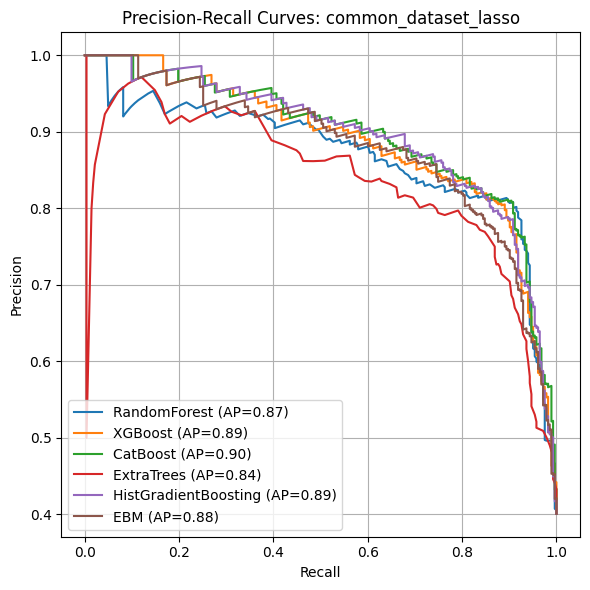

In [ ]:
X = all_datasets["case_2"]["common_dataset_lasso"].drop(columns=["target"])
y = all_datasets["case_2"]["common_dataset_lasso"]["target"]

plot_precision_recall_curves(X, y, dataset_name="common_dataset_lasso")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:09:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


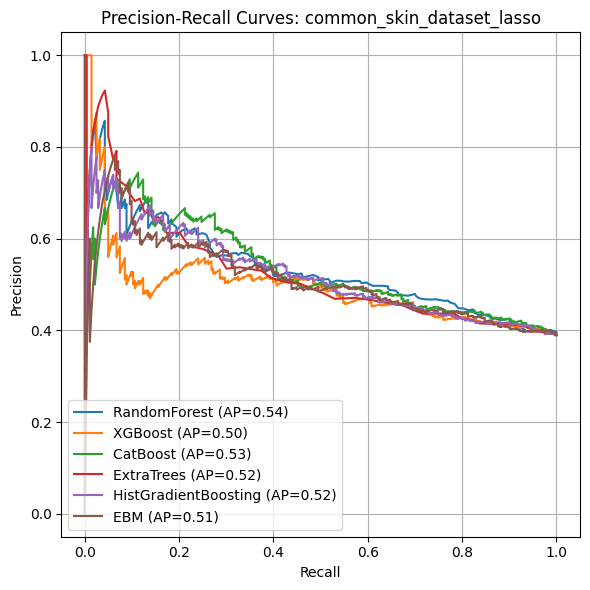

In [ ]:
X = all_datasets["case_2"]["common_skin_dataset_lasso"].drop(columns=["target"])
y = all_datasets["case_2"]["common_skin_dataset_lasso"]["target"]

plot_precision_recall_curves(X, y, dataset_name="common_skin_dataset_lasso")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:17:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:868: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


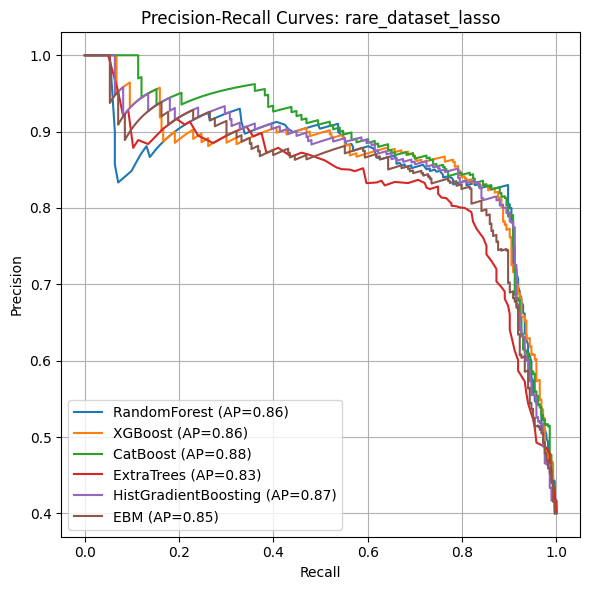

In [ ]:
X = all_datasets["case_2"]["rare_dataset_lasso"].drop(columns=["target"])
y = all_datasets["case_2"]["rare_dataset_lasso"]["target"]

plot_precision_recall_curves(X, y, dataset_name="rare_dataset_lasso")

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [22:28:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.11/dist-packages/interpret/glassbox/_ebm/_ebm.py:868: UserWarning: Missing values detected. Our visualizations do not currently display missing values. To retain the glassbox nature of the model you need to either set the missing values to an extreme value like -1000 that will be visible on the graphs, or manually examine the missing value score in ebm.term_scores_[term_index][0]
  warn(


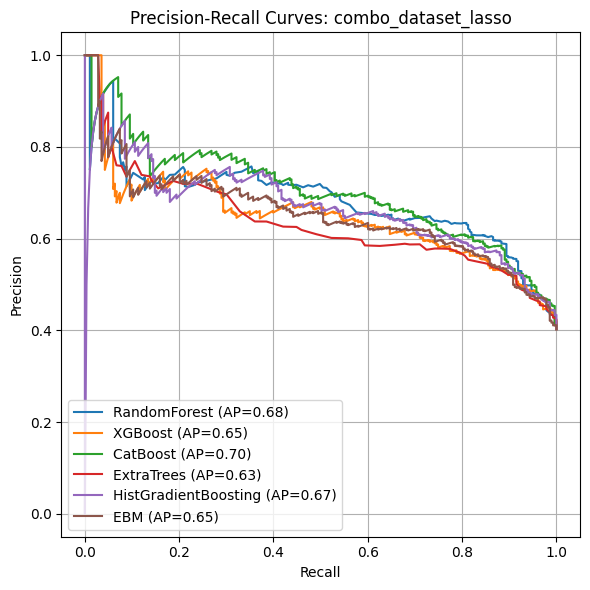

In [ ]:
X = all_datasets["case_2"]["combo_dataset_lasso"].drop(columns=["target"])
y = all_datasets["case_2"]["combo_dataset_lasso"]["target"]

plot_precision_recall_curves(X, y, dataset_name="combo_dataset_lasso")

## 3. Feature Importance Graphs

In [ ]:
# Step 1: Get best model per dataset based on custom criteria
best_models_df = (
    model_results_df[~model_results_df["PR AUC"].isnull()]
    .sort_values(by=["Dataset", "PR AUC", "F1 Score", "FPR"], ascending=[True, False, False, True])
    .groupby("Dataset")
    .first()
    .reset_index()
)

print(best_models_df[["Dataset", "Model", "PR AUC", "F1 Score", "FPR"]])

                     Dataset         Model  PR AUC  F1 Score   FPR
0        combo_dataset_lasso      CatBoost   0.703     0.659 0.212
1       common_dataset_lasso      CatBoost   0.896     0.842 0.137
2  common_skin_dataset_lasso  RandomForest   0.536     0.364 0.122
3         rare_dataset_lasso      CatBoost   0.883     0.843 0.123



=== Processing combo_dataset_lasso with CatBoost ===


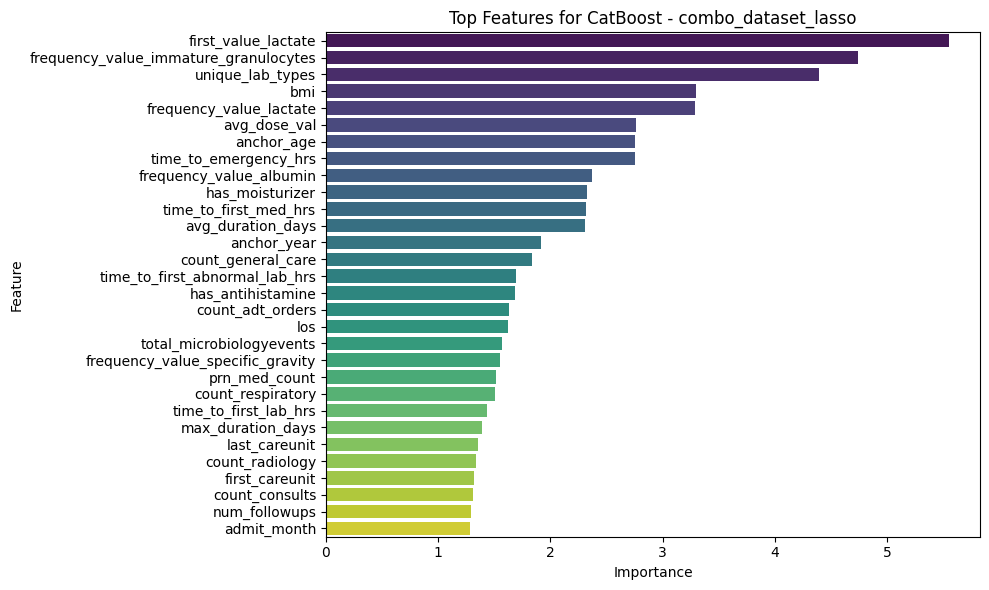


=== Processing common_dataset_lasso with CatBoost ===


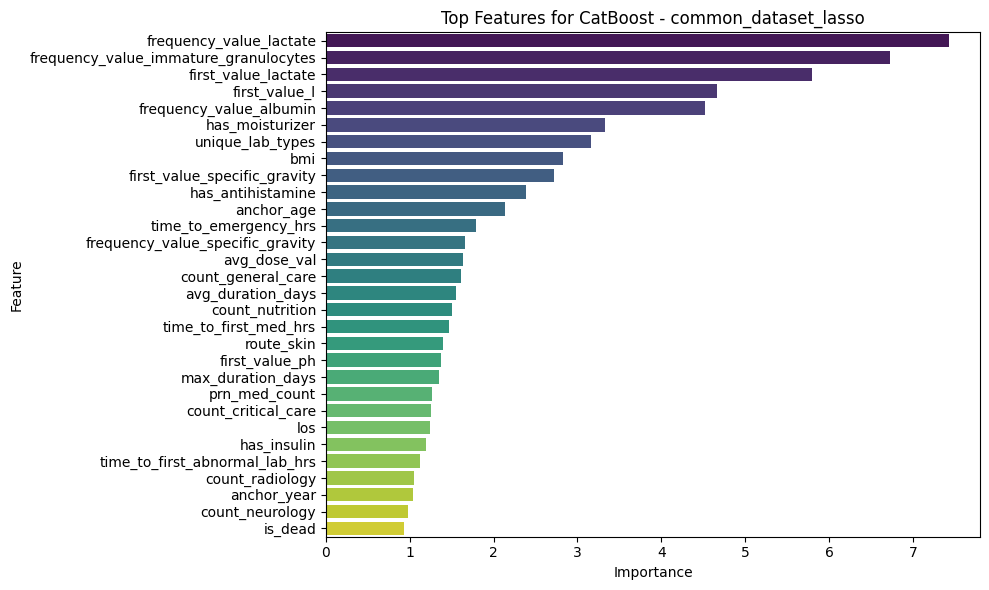


=== Processing common_skin_dataset_lasso with RandomForest ===


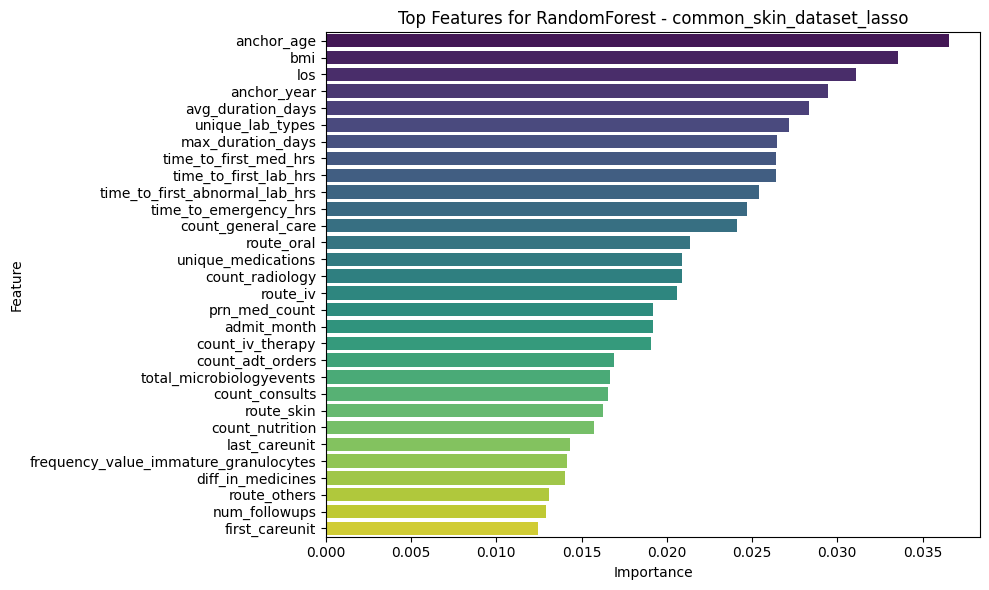


=== Processing rare_dataset_lasso with CatBoost ===


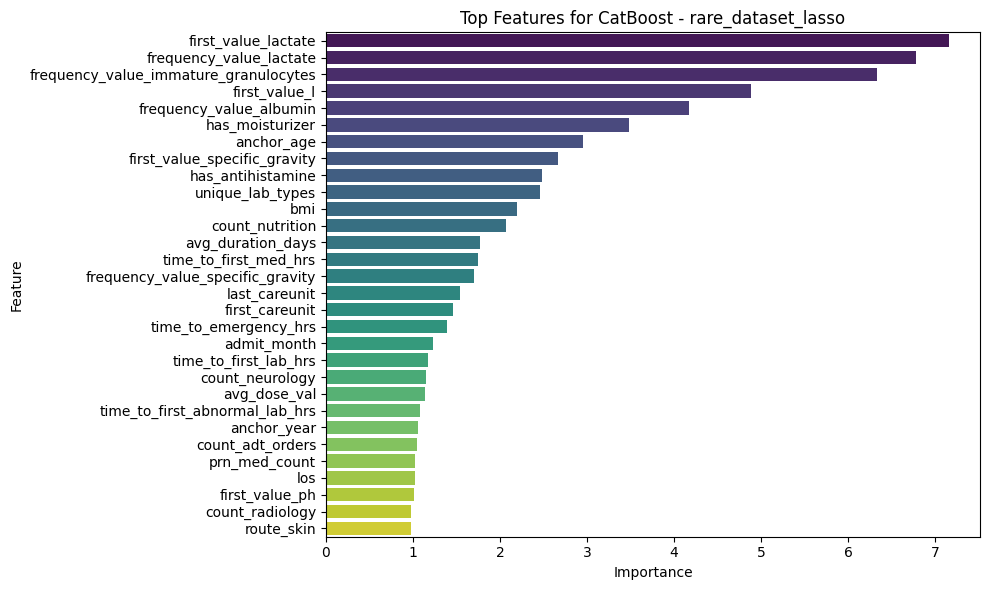

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier, AdaBoostClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from interpret.glassbox import ExplainableBoostingClassifier

# Step 2: Loop over best models and plot feature importances
for i, row in best_models_df.iterrows():
    dataset_name = row["Dataset"]
    model_name = row["Model"]

    print(f"\n=== Processing {dataset_name} with {model_name} ===")

    # Get the dataset
    df = all_datasets["case_2"][dataset_name]
    X = df.drop(columns=["target"])
    y = df["target"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

    # Instantiate the selected model
    if model_name == "RandomForest":
        model = RandomForestClassifier(n_estimators=400, random_state=42)
    elif model_name == "XGBoost":
        model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', missing=np.nan)
    elif model_name == "CatBoost":
        model = CatBoostClassifier(verbose=0)
    elif model_name == "ExtraTrees":
        model = ExtraTreesClassifier(n_estimators=100, random_state=42)
    elif model_name == "HistGradientBoosting":
        model = HistGradientBoostingClassifier()
    elif model_name == "EBM":
        model = ExplainableBoostingClassifier()
    else:
        print(f"Model {model_name} not supported.")
        continue

    # Fit the model
    model.fit(X_train, y_train)

    # Compute feature importances
    try:
        if hasattr(model, "feature_importances_") and np.sum(model.feature_importances_) > 0:
            importances = model.feature_importances_
            features = X.columns
        elif model_name == "EBM":
            global_exp = model.explain_global()
            features = [feat["name"] for feat in global_exp.data()]
            importances = [feat["scores"][0] for feat in global_exp.data()]
        else:
            # Use permutation importance as fallback
            print("Using permutation importance...")
            result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='f1')
            importances = result.importances_mean
            features = X.columns
    except Exception as e:
        print(f"Failed to get feature importances for {model_name}: {e}")
        continue

    # Create importance dataframe
    importance_df = pd.DataFrame({
        "Feature": features,
        "Importance": importances
    }).sort_values("Importance", ascending=False).head(30)

    # Plot
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x="Importance", y="Feature", palette="viridis")
    plt.title(f"Top Features for {model_name} - {dataset_name}")
    plt.tight_layout()
    plt.show()

In [ ]:
case_2_df.groupby('first_value_lactate')['target'].value_counts()

first_value_lactate  target
-99999.000           0         3569
                     1          911
0.200                0            1
0.400                0            5
0.500                0           11
                     1            1
0.600                0           45
                     1            4
0.700                0           90
                     1            7
0.740                0            1
0.800                0          141
                     1           18
0.900                0          234
                     1           23
1.000                0          262
                     1           28
1.010                0            1
1.100                0          333
                     1           27
1.190                0            1
1.200                0          346
                     1           37
1.210                0            1
1.270                0            1
1.300                0          331
                     1           26
1.340                0            1
1.400                0          331
                     1           34
1.500                0          323
                     1           31
1.600                0          288
                     1           29
1.700                0          221
                     1           31
1.800                0          212
                     1           20
1.900                0          199
                     1           14
2.000                0          187
                     1           15
2.100                0          131
                     1           12
2.160                0            1
2.200                0          128
                     1           21
2.300                0          112
                     1           12
2.400                0          126
                     1           12
2.500                0           97
                     1            7
2.600                0           78
                     1            5
2.700                0           59
                     1           11
2.800                0           52
                     1            6
2.900                0           60
                     1            4
3.000                0           53
                     1            8
3.100                0           45
                     1            4
3.200                0           22
                     1            7
3.300                0           25
                     1            5
3.400                0           30
                     1            2
3.500                0           33
                     1            1
3.600                0           29
3.700                0           23
                     1            4
3.800                0           23
                     1            5
3.900                0           24
                     1            3
4.000                0           22
                     1            2
4.100                0           11
                     1            2
4.200                0           14
                     1            2
4.300                0           23
4.400                0           15
                     1            4
4.500                0            9
                     1            2
4.600                0           13
4.700                0            7
                     1            1
4.800                0            7
                     1            1
4.900                0           16
5.000                0           10
5.100                0            7
                     1            2
5.200                0           13
                     1            2
5.300                0            9
                     1            1
5.400                0            8
5.500                0            5
                     1            1
5.600                0            5
                     1            1
5.700                0            4
5.800       

##Writing all the datasets back to disk

In [ ]:
# Flatten all_datasets into individual DataFrames
for case_name, dataset_dict in all_datasets.items():
    for dataset_name, df in dataset_dict.items():
        variable_name = f"{case_name}_{dataset_name}".replace("-", "_")
        globals()[variable_name] = df.copy()
        print(f"Created DataFrame: {variable_name}")

Created DataFrame: case_2_rare_dataset
Created DataFrame: case_2_combo_dataset
Created DataFrame: case_2_common_dataset_lasso
Created DataFrame: case_2_rare_dataset_lasso
Created DataFrame: case_2_common_skin_dataset_lasso
Created DataFrame: case_2_combo_dataset_lasso


In [ ]:
#Saving the files
case_2_common_dataset_lasso.to_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/common_lasso_dataset.csv",index=False, header = True)
case_2_combo_dataset_lasso.to_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/combo_lasso_dataset.csv",index=False, header = True)
case_2_rare_dataset_lasso.to_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/rare_lasso_dataset.csv",index=False, header = True)
case_2_common_skin_dataset_lasso.to_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/common_skin_lasso_dataset.csv",index=False, header = True)
future_rare_skin_case_2.to_csv("/content/drive/MyDrive/ColabNotebooks/Rare_Diseases_Research/Data/late_diagnosis_rare_skin.csv",index=False, header = True)